# Project Overview

This project aims to optimize the allocation of funds within a portfolio selection.

This will be explored by leveraging the following techniques:
- Sharpe Ratio
- Monte Carlo Method
- Volatlity
- Efficient Fronter (Modern Portfolio Theory)

## Our Imports

In [150]:
import pandas as pd  
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import quandl
import scipy.optimize as sco

plt.style.use('fivethirtyeight')
np.random.seed(777)

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Get Data

For this project, we will be leveraging quandl and its free API service to retrieve stock information. AlphaVantage's API was helpful in the previous project but it had some limitations regarding accessing data information and setting data ranges. So we will use quandl's service moving forward.

In [151]:
stocks = ['AAPL','AMZN','GOOGL','FB']
data = quandl.get_table('WIKI/PRICES', ticker = stocks,
                        qopts = { 'columns': ['date', 'ticker', 'adj_close'] },
                        date = { 'gte': '2016-1-1', 'lte': '2017-12-31' }, paginate=True)

In [152]:
data.head()

,date,ticker,adj_close
None,,,
0,2017-12-29,GOOGL,1053.40
1,2017-12-28,GOOGL,1055.95
2,2017-12-27,GOOGL,1060.20
3,2017-12-26,GOOGL,1065.85
4,2017-12-22,GOOGL,1068.86


Text(0,0.5,'Date')

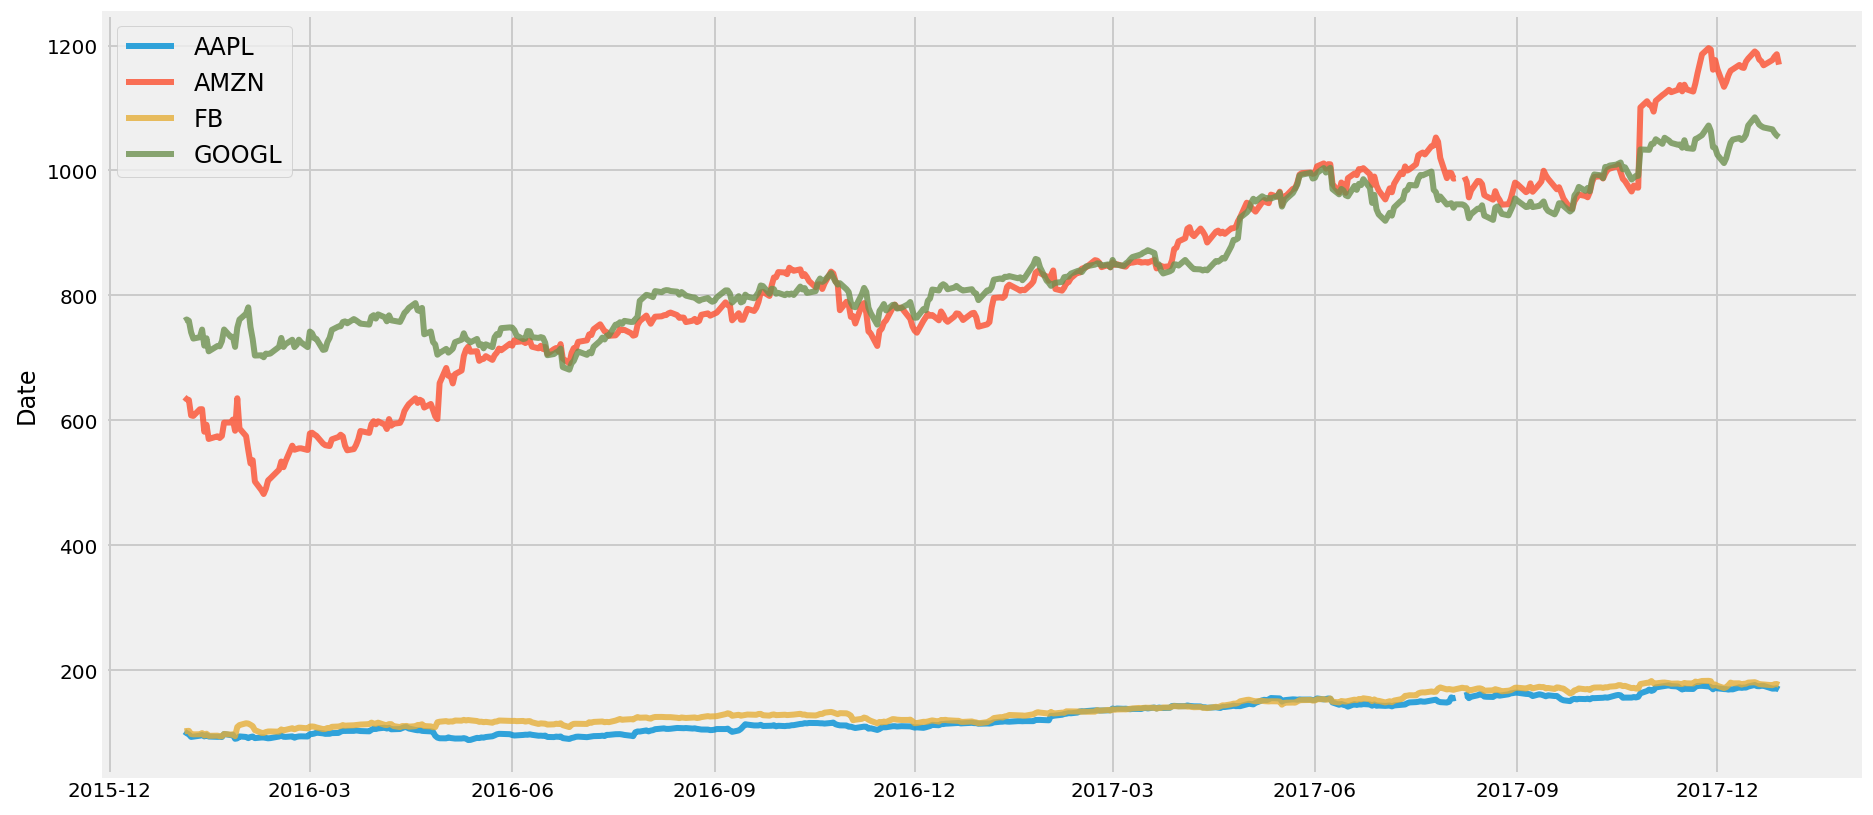

In [153]:
df = data.set_index('date')
table = df.pivot(columns='ticker')
table.columns = [col[1] for col in table.columns]
table.head()
plt.figure(figsize=(14, 7))
for c in table.columns.values:
    plt.plot(table.index, table[c], lw=3, alpha=0.8,label=c)
plt.legend(loc='upper left', fontsize=12)
plt.ylabel('Price ($)')
plt.ylabel('Date')

## Establish Our Portfolio

Let's establish our portfolio here. We will leverage the functions designed previously and extend them further to include the new API call. 

Let us also assume that we have the the ability to purchase only 100 shares of all our stock choices combined. This way we do not have to deal with the calculation of left over funds and whether the remainder should be used to buy other stock choices.

### Portfolio Performance Function

The function below will calculate the returns and volatiltiy for a given time range. By default we will be evaluating these metrics on a daily basis. However, we've extended this function to account for them on a monthly basis as well.

Looking to the code of this function, it essentially calculates two things. 

1. First and foremost, it calculates the sum of daily returns through the multiplication of its allocation or "weights". We then multiply this by the annual factor to figure out returns for a period of time. 

2. Secondly, we calculate the standard deviation through the dot product of the covariance of the returns dotted with its allocation. We then dot the data associated with weights through T with the product of that calculation. Next we multiply the squareroot of the previous calculation with the root of the chosen annual factor.

3. Lastly, we return these two calculations as std and returns.

In [154]:
def portfolioPerformance(weights, mean_returns, cov_matrix, freq="daily"):
    
    if freq == "daily":
        annualFactor = 252
    elif freq == "monthly":
        annualFactor = 12
    else:
        annualFactor = 1
        
    returns = np.sum(mean_returns*weights ) *annualFactor
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(annualFactor)
    return std, returns

### Randomize Portfolio Allocation

While it would be fun to play around with the portfolio allocation individually, it would be easier to just randomize it and see how different allocations affect our portfolio's performance. Below, we have a function that does exactly that. 

You will notice that it does a calculation of volatility to results[0,i] and sharpe ratio to results[2,i].

In [155]:
def randomizePortfolio(numPortfolios, meanDailyReturns, covMatrix, riskFreeRate):
    results = np.zeros((3,numPortfolios))
    weights_record = []
    for i in range(numPortfolios):
        weights = np.random.random(4)
        weights /= np.sum(weights)
        weights_record.append(weights)
        portfolio_std_dev, portfolio_return = portfolioPerformance(weights, meanDailyReturns, covMatrix)
        results[0,i] = portfolio_std_dev
        results[1,i] = portfolio_return
        results[2,i] = (portfolio_return - riskFreeRate) / portfolio_std_dev
    return results, weights_record

Now let's start assigning the data. Some key things stand out:

- dailyReturns: We can easily compute daily returns through the usage of the pct_change function. So let's called that on our table.
- meanDailyReturns: Finding the mean is as simple as calling the mean function.
- covMatrix: Finding the covariance is as easy as calling the cov function.
- numPortfolios: The number of random portfolios we'd like to experiment with
- riskFreeRate: This number was determined by using the rates at the start of 2018 to apply to our historical data ranging for the year of 2017.

In [156]:
dailyReturns = table.pct_change()
meanDailyReturns = dailyReturns.mean()
covMatrix = dailyReturns.cov()
numPortfolios = 100009
riskFreeRate = 0.0178

### Display Randomly Allocated Portfolio 

Now let's have a look at how our randomly allocated portfolio is doing. We will leverage the function below to display the portfolio with the highest Sharpe Ratio and another portfolio with the lowest volatility. These calculations were performed within the randomizePortfolio function and passed on here.

In [157]:
def displayRandomPortfolio(meanDailyReturns, covMatrix, numPortfolios, riskFreeRate):
    results, weights = randomizePortfolio(numPortfolios,meanDailyReturns, covMatrix, riskFreeRate)
    
    max_sharpe_idx = np.argmax(results[2])
    sdp, rp = results[0,max_sharpe_idx], results[1,max_sharpe_idx]
    max_sharpe_allocation = pd.DataFrame(weights[max_sharpe_idx],index=table.columns,columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T
    
    min_vol_idx = np.argmin(results[0])
    sdp_min, rp_min = results[0,min_vol_idx], results[1,min_vol_idx]
    min_vol_allocation = pd.DataFrame(weights[min_vol_idx],index=table.columns,columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T
    
    print ("-"*80)
    print ("Maximum Sharpe Ratio Portfolio Allocation\n")
    print ("Annualised Return:", round(rp,2))
    print ("Annualised Volatility:", round(sdp,2))
    print ("\n")
    print (max_sharpe_allocation)
    print ("-"*80)
    print ("Minimum Volatility Portfolio Allocation\n")
    print ("Annualised Return:", round(rp_min,2))
    print ("Annualised Volatility:", round(sdp_min,2))
    print ("\n")
    print (min_vol_allocation)
    
    plt.figure(figsize=(10, 7))
    plt.scatter(results[0,:],results[1,:],c=results[2,:],cmap='RdYlGn', marker='o', s=10, alpha=0.3)
    plt.colorbar()
    plt.scatter(sdp,rp,marker='*',color='r',s=300, label='Maximum Sharpe ratio')
    plt.scatter(sdp_min,rp_min,marker='*',color='g',s=300, label='Minimum volatility')
    plt.title('Simulated Portfolio Optimization')
    plt.xlabel('Annualised Volatility')
    plt.ylabel('Annualised Returns')
    plt.legend(labelspacing=0.8)

--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Annualised Return: 0.3
Annualised Volatility: 0.18


             AAPL   AMZN     FB  GOOGL
allocation  43.93  29.49  26.51   0.07
--------------------------------------------------------------------------------
Minimum Volatility Portfolio Allocation

Annualised Return: 0.22
Annualised Volatility: 0.16


            AAPL  AMZN    FB  GOOGL
allocation  33.2  0.34  6.62  59.84


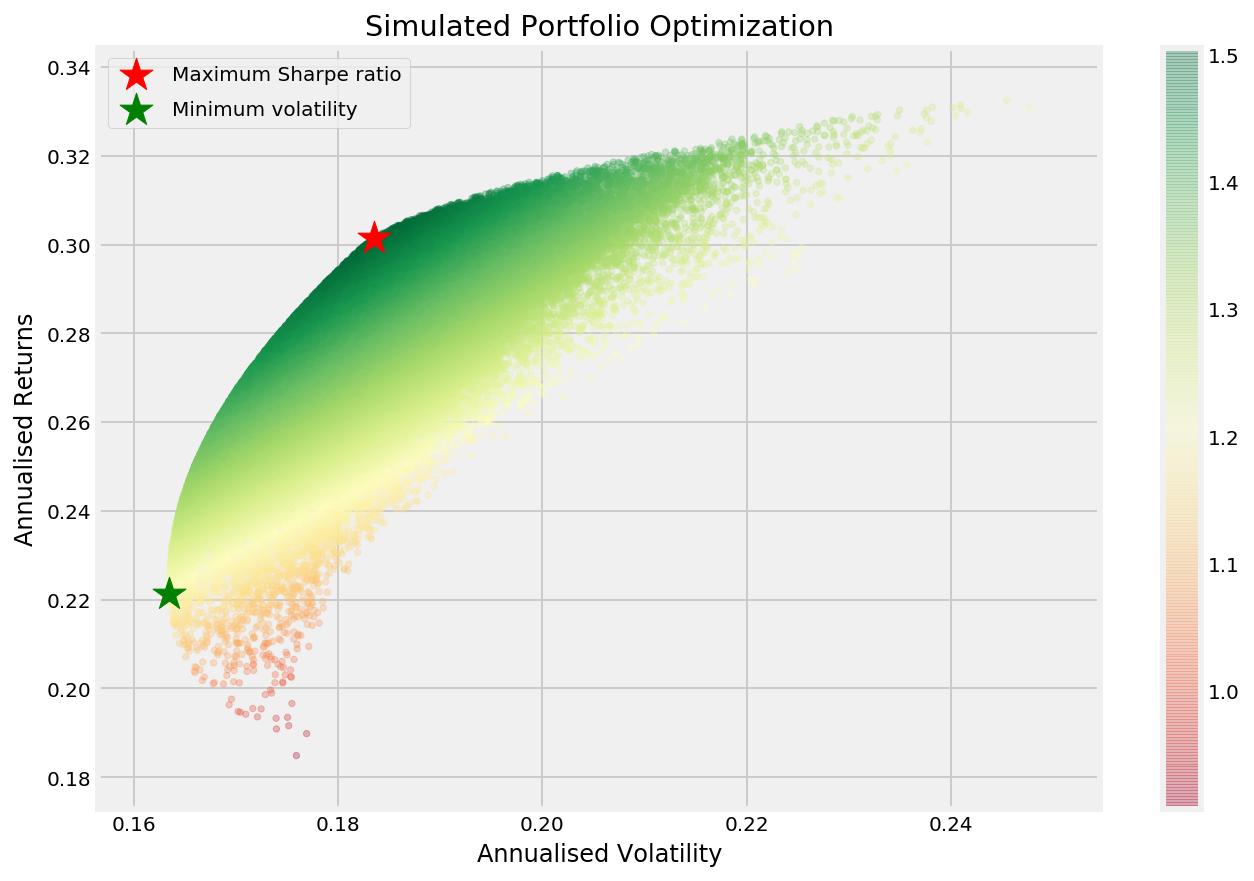

In [158]:
displayRandomPortfolio(meanDailyReturns, covMatrix, numPortfolios, riskFreeRate)

### Modern Portfolio Theory and The Efficient Frontier

To interpret this chart, we first need to understand what the modern portfolio theory is and this idea of the efficient frontier.

Well first, we have to give thanks to Harry Markowitz for pioneering this idea. Now, let's look to the assumptions the Modern Portfolio Theory (MPT hereafter) holds.

MPT assumptions:
- Investors are rational and avoid risks whenever possible
- Investors aim for the maximum returns for their investment
- All investors share the aim maximizing their expected returns
- Commissions and taxes on the market are left out of consideration
- All investors have access to the same sources and level of all necessary information about investment decisions
- Investors have unlimited access to borrow and lend money at the risk free rate

MPT is a theory about how investors (who are risk averse) construct portfolios that maximise their expected returns for given levels of risk. The breakthrough insight from MPT was the fact that risks and returns characteristics of various investments need not be isolated and analysed but looked at how these investments affected the performance of a portfolio. The assumptions of MPT, thus, emphasise that investors only assume additional risk when there is a possibility of higher expected returns — “High risk, High Reward”

Essentially it boils down to this theory that investors can create an efficient set of portfolios otherwise known as the Efficient Frontier. Where this frontier offers the maximum expected returns for any given level of risk. So if an investor chooses a lower risk, the efficient frontier theory will yield them the maximum expected level of return for that assumed level of risk and vice versa.

Below we can see this idea of the Efficient Frontier conceptualized:

![title](https://cdn-images-1.medium.com/max/1600/1*4Ke6NhIUYPR12Sa2nrIpxw.jpeg)

### Efficient Frontier Function

We can actually form an Efficient Frontier with the chart of our Simulated Portfolio Optimizer! But we'll need a few functions to compute the efficient return and the overall efficient frontier.

In [159]:
def portfolio_volatility(weights, mean_returns, cov_matrix):
    return portfolioPerformance(weights, mean_returns, cov_matrix)[0]

def efficient_return(mean_returns, cov_matrix, target):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)

    def portfolio_return(weights):
        return portfolioPerformance(weights, mean_returns, cov_matrix)[1]
    
    constraints = ({'type': 'eq', 'fun': lambda x: portfolio_return(x) - target},
                   {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0,1) for asset in range(num_assets))
    result = sco.minimize(portfolio_volatility, num_assets*[1./num_assets,], args=args, method='SLSQP', bounds=bounds, constraints=constraints)
    return result


def efficient_frontier(mean_returns, cov_matrix, returns_range):
    efficients = []
    for ret in returns_range:
        efficients.append(efficient_return(mean_returns, cov_matrix, ret))
    return efficients

In [160]:
def efficientFrontierRandomPortfolio(meanDailyReturns, covMatrix, numPortfolios, riskFreeRate):
    results, weights = randomizePortfolio(numPortfolios,meanDailyReturns, covMatrix, riskFreeRate)
    
    max_sharpe_idx = np.argmax(results[2])
    sdp, rp = results[0,max_sharpe_idx], results[1,max_sharpe_idx]
    max_sharpe_allocation = pd.DataFrame(weights[max_sharpe_idx],index=table.columns,columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T
    
    min_vol_idx = np.argmin(results[0])
    sdp_min, rp_min = results[0,min_vol_idx], results[1,min_vol_idx]
    min_vol_allocation = pd.DataFrame(weights[min_vol_idx],index=table.columns,columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T
    
    print ("-"*80)
    print ("Maximum Sharpe Ratio Portfolio Allocation\n")
    print ("Annualised Return:", round(rp,2))
    print ("Annualised Volatility:", round(sdp,2))
    print ("\n")
    print (max_sharpe_allocation)
    print ("-"*80)
    print ("Minimum Volatility Portfolio Allocation\n")
    print ("Annualised Return:", round(rp_min,2))
    print ("Annualised Volatility:", round(sdp_min,2))
    print ("\n")
    print (min_vol_allocation)
        
    plt.figure(figsize=(10, 7))
    plt.scatter(results[0,:],results[1,:],c=results[2,:],cmap='RdYlGn', marker='o', s=10, alpha=0.3)
    plt.colorbar()
    plt.scatter(sdp,rp,marker='*',color='r',s=300, label='Maximum Sharpe ratio')
    plt.scatter(sdp_min,rp_min,marker='*',color='g',s=300, label='Minimum volatility')

    target = np.linspace(rp_min, 0.32, 50)
    efficient_portfolios = efficient_frontier(meanDailyReturns, covMatrix, target)
    plt.plot([p['fun'] for p in efficient_portfolios], target, linestyle='-.', color='black', label='Efficient Frontier')
    plt.title('Simulated Portfolio Optimization Displaying The Efficient Frontier')
    plt.xlabel('Annualised Volatility')
    plt.ylabel('Annualised Returns')
    plt.legend(labelspacing=0.8)

--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Annualised Return: 0.3
Annualised Volatility: 0.18


             AAPL   AMZN     FB  GOOGL
allocation  45.08  31.36  23.41   0.15
--------------------------------------------------------------------------------
Minimum Volatility Portfolio Allocation

Annualised Return: 0.22
Annualised Volatility: 0.16


             AAPL  AMZN    FB  GOOGL
allocation  34.31  0.66  6.55  58.48


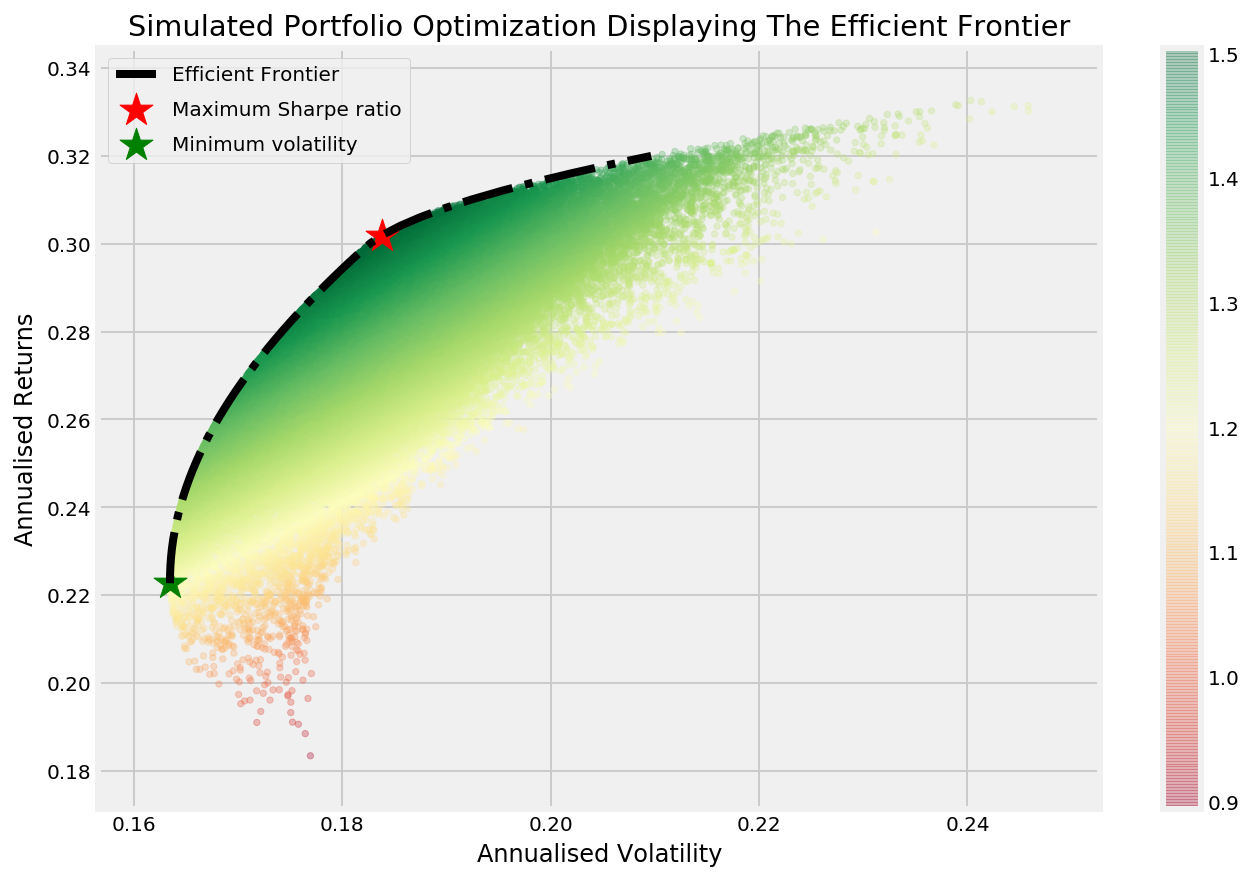

In [161]:
efficientFrontierRandomPortfolio(meanDailyReturns, covMatrix, numPortfolios, riskFreeRate)

What a beautiful display of the efficient frontier! I will admit, I had some trouble showcasing this concept with other stock choices and and certain time ranges. It probably has to do with with the choices of the allocation. For example, if we do the below, we find that the efficient frontier is not as prominent.

In [166]:
stocks = ['AAPL','AMZN','GOOGL','TSLA']
data = quandl.get_table('WIKI/PRICES', ticker = stocks,
                        qopts = { 'columns': ['date', 'ticker', 'adj_close'] },
                        date = { 'gte': '2018-1-1', 'lte': '2018-12-31' }, paginate=True)

df = data.set_index('date')
table = df.pivot(columns='ticker')
table.columns = [col[1] for col in table.columns]
table.head()

,AAPL,AMZN,GOOGL,TSLA
date,,,,
2018-01-02,172.26,1189.01,1073.21,320.53
2018-01-03,172.23,1204.20,1091.52,317.25
2018-01-04,173.03,1209.59,1095.76,314.62
2018-01-05,175.00,1229.14,1110.29,316.58
2018-01-08,174.35,1246.87,1114.21,336.41


--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Annualised Return: 1.01
Annualised Volatility: 0.29


            AAPL   AMZN  GOOGL  TSLA
allocation  0.49  97.51   0.37  1.64
--------------------------------------------------------------------------------
Minimum Volatility Portfolio Allocation

Annualised Return: 0.29
Annualised Volatility: 0.24


             AAPL   AMZN  GOOGL  TSLA
allocation  53.46  35.18    6.8  4.56


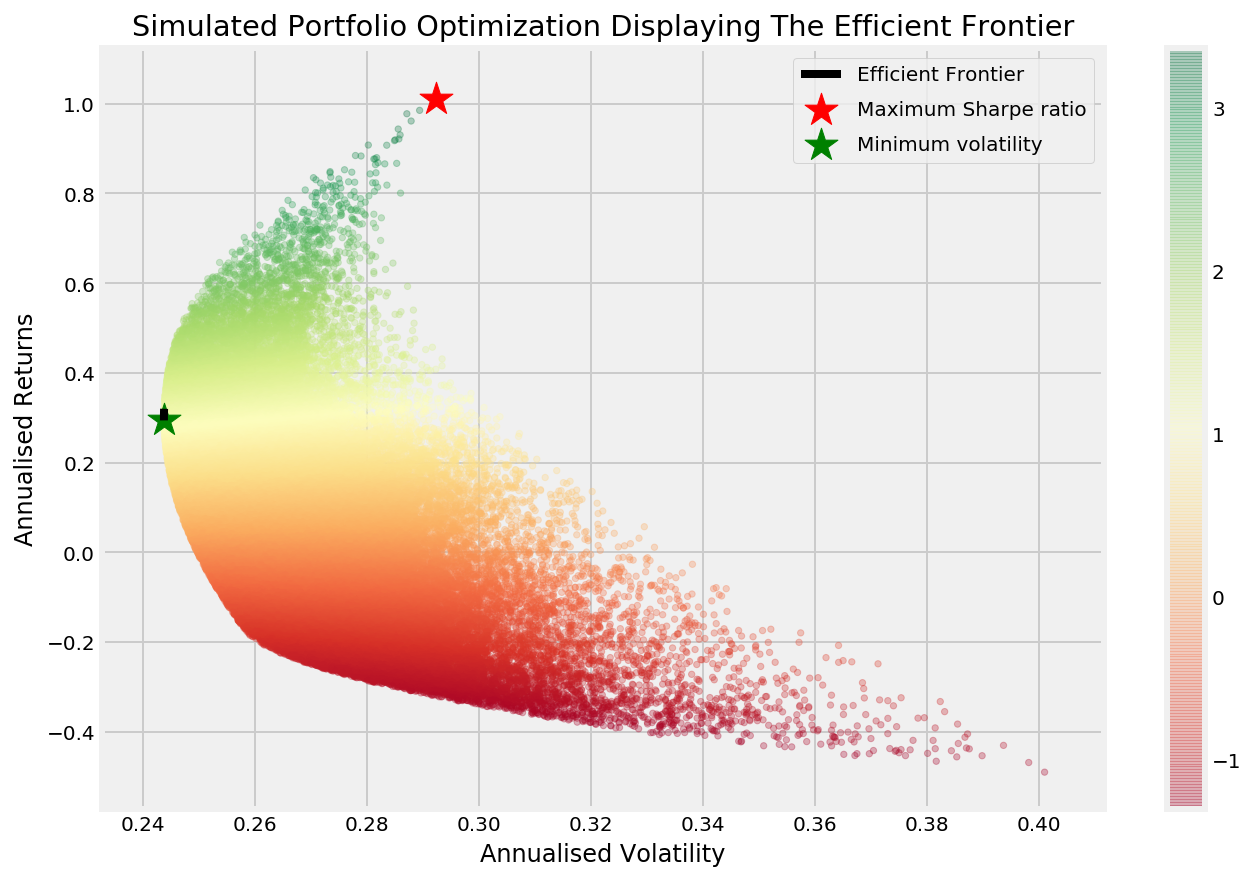

In [164]:
dailyReturns = table.pct_change()
meanDailyReturns = dailyReturns.mean()
covMatrix = dailyReturns.cov()
numPortfolios = 100009
riskFreeRate = 0.0252

efficientFrontierRandomPortfolio(meanDailyReturns, covMatrix, numPortfolios, riskFreeRate)

For the chosen data above, we find that the efficient frontier is far less prominent and pronounced. 

Why is this the case?

# Optimizations

Let's go back to our stock choices for ease of computations.

In [190]:
stocks = ['AAPL','AMZN','GOOGL','FB']
data = quandl.get_table('WIKI/PRICES', ticker = stocks,
                        qopts = { 'columns': ['date', 'ticker', 'adj_close'] },
                        date = { 'gte': '2016-1-1', 'lte': '2017-12-31' }, paginate=True)

df = data.set_index('date')
table = df.pivot(columns='ticker')
table.columns = [col[1] for col in table.columns]
table.head()

,AAPL,AMZN,FB,GOOGL
date,,,,
2016-01-04,101.783763,636.99,102.22,759.44
2016-01-05,99.233131,633.79,102.73,761.53
2016-01-06,97.291172,632.65,102.97,759.33
2016-01-07,93.185040,607.94,97.92,741.00
2016-01-08,93.677776,607.05,97.33,730.91


In [191]:
dailyReturns = table.pct_change()
meanDailyReturns = dailyReturns.mean()
covMatrix = dailyReturns.cov()
numPortfolios = 100009
riskFreeRate = 0.0252

## Maximimze for Sharpe Ratio

Now we will create our maximizer function to maximime our portfolio for the sharpe ratio. 

If you recall, the sharpe ratio is simply: 

![title](https://www.macroption.com/images/formulas/sharpe-ratio-formula-explained.png)

In [192]:
def neg_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate):
    p_var, p_ret = portfolioPerformance(weights, mean_returns, cov_matrix)
    return -(p_ret - risk_free_rate) / p_var

def max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix, risk_free_rate)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0,1.0)
    bounds = tuple(bound for asset in range(num_assets))
    result = sco.minimize(neg_sharpe_ratio, num_assets*[1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)
    return result

## Optimize Using Sharpe Ratio

Now let's optimize our portfolio for the maximum possible sharpe ratio.

In [193]:
def optimizedSR(mean_returns, cov_matrix, num_portfolios, risk_free_rate):
    results, _ = randomizePortfolio(num_portfolios,mean_returns, cov_matrix, risk_free_rate)
    
    max_sharpe = max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate)
    sdp, rp = portfolioPerformance(max_sharpe['x'], mean_returns, cov_matrix)
    max_sharpe_allocation = pd.DataFrame(max_sharpe.x,index=table.columns,columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T
    max_sharpe_allocation
    
    print ("-"*80)
    print ("Maximum Sharpe Ratio Portfolio Allocation\n")
    print ("Annualised Return:", round(rp,2))
    print ("Annualised Volatility:", round(sdp,2))
    print ("\n")
    print (max_sharpe_allocation)

In [194]:
optimizedSR(meanDailyReturns, covMatrix, numPortfolios, riskFreeRate)

--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Annualised Return: 0.3
Annualised Volatility: 0.18


             AAPL   AMZN     FB  GOOGL
allocation  44.41  29.43  26.16    0.0


## Minimize for Volatility

If your recall, volatlity is simply...

In [195]:
def portfolio_volatility(weights, mean_returns, cov_matrix):
    return portfolioPerformance(weights, mean_returns, cov_matrix)[0]

def min_variance(mean_returns, cov_matrix):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0,1.0)
    bounds = tuple(bound for asset in range(num_assets))

    result = sco.minimize(portfolio_volatility, num_assets*[1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)

    return result

In [196]:
def optimizedVol(mean_returns, cov_matrix, num_portfolios, risk_free_rate):
    results, _ = randomizePortfolio(num_portfolios,mean_returns, cov_matrix, risk_free_rate)
    
    min_vol = min_variance(mean_returns, cov_matrix)
    sdp_min, rp_min = portfolioPerformance(min_vol['x'], mean_returns, cov_matrix)
    min_vol_allocation = pd.DataFrame(min_vol.x,index=table.columns,columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T
    
    print ("-"*80)
    print ("Minimum Volatility Portfolio Allocation\n")
    print ("Annualised Return:", round(rp_min,2))
    print ("Annualised Volatility:", round(sdp_min,2))
    print ("\n")
    print (min_vol_allocation)

In [197]:
optimizedVol(meanDailyReturns, covMatrix, numPortfolios, riskFreeRate)

--------------------------------------------------------------------------------
Minimum Volatility Portfolio Allocation

Annualised Return: 0.22
Annualised Volatility: 0.16


             AAPL  AMZN    FB  GOOGL
allocation  34.02  0.73  6.98  58.26


## Plot Our Optimizations

In [198]:
def plotOptimizations(mean_returns, cov_matrix, num_portfolios, risk_free_rate):
    results, _ = randomizePortfolio(num_portfolios,mean_returns, cov_matrix, risk_free_rate)
    
    max_sharpe = max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate)
    sdp, rp = portfolioPerformance(max_sharpe['x'], mean_returns, cov_matrix)
    max_sharpe_allocation = pd.DataFrame(max_sharpe.x,index=table.columns,columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T
    max_sharpe_allocation
    
    min_vol = min_variance(mean_returns, cov_matrix)
    sdp_min, rp_min = portfolioPerformance(min_vol['x'], mean_returns, cov_matrix)
    min_vol_allocation = pd.DataFrame(min_vol.x,index=table.columns,columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T
        
    plt.figure(figsize=(10, 7))
    plt.scatter(results[0,:],results[1,:],c=results[2,:],cmap='RdYlGn', marker='o', s=10, alpha=0.3)
    plt.colorbar()
    plt.scatter(sdp,rp,marker='*',color='r',s=300, label='Maximum Sharpe ratio')
    plt.scatter(sdp_min,rp_min,marker='*',color='g',s=300, label='Minimum volatility')

    target = np.linspace(rp_min, 0.32, 50)
    efficient_portfolios = efficient_frontier(meanDailyReturns, covMatrix, target)
    plt.plot([p['fun'] for p in efficient_portfolios], target, linestyle='-.', color='black', label='Efficient Frontier')
    plt.title('Calculated Portfolio Optimization Displaying The Efficient Frontier')
    plt.xlabel('Annualised Volatility')
    plt.ylabel('Annualised Returns')
    plt.legend(labelspacing=0.8)

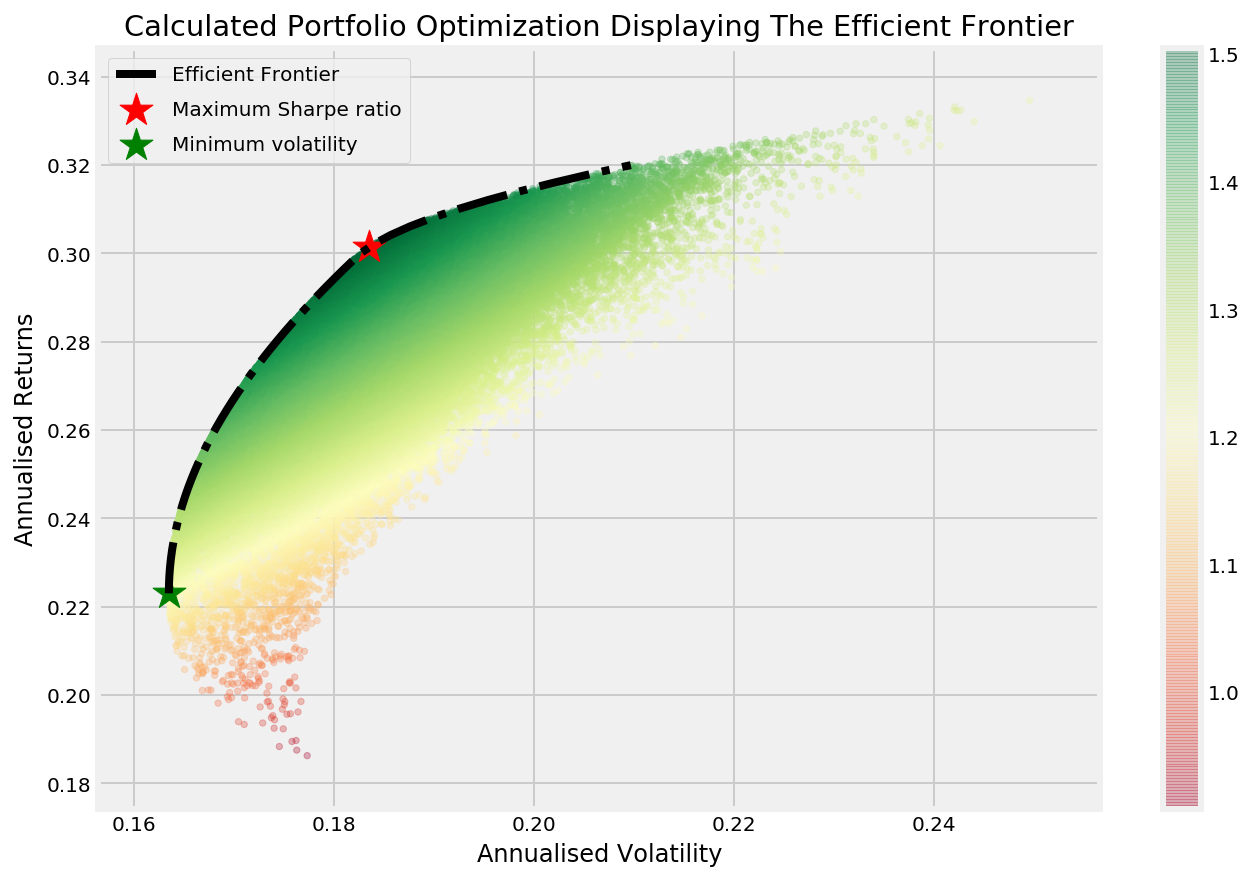

In [199]:
plotOptimizations(meanDailyReturns, covMatrix, numPortfolios, riskFreeRate)